In [1]:
from collections import Counter

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

# Introduction

After reading this notebook, you can answer below questions

- There is a coin tossing gamble. The coin is fair. If the head comes out, you can get three times as much money as you bet. But, if the tail comes out, you lose all your bet. What is the optimal bet size for this game?


- There is another game. It is a dice gamble. The dice is fair and there are numbers from one to six on each side. If you throw the dice and the number six comes out, this game will return nine times the money you bet. But other numbers come out, you lose all you bet. Between the coin game described above and the dice game, which game is advantageous, and how much money should you bet on each game?


- How can we use the Kelly formula when investing in a single stock or running a portfolio in the stock market?


- In the real world, what should you take care of when applying the Kelly Criterion?

## Why do we need to care about bet size?

 Let's say there is a coin tossing gamble and the coin is fair. If the head comes out, you can get two times as much money as you bet. But, if the tail comes out, you lose all your bet. If there are ten thousand of people whose initial capital is $100 and they have to bet all of their bankroll at every game. What will be the result? 

In [2]:
def toss_coin(prob_head, bankroll, odds, fraction):
    coin_toss = np.random.binomial(1, prob_head)
    if coin_toss == 1:
        return bankroll*((1+odds*fraction)**coin_toss)
    else:
        return bankroll*(1-fraction)

In [3]:
def coin_simulation(max_trials, prob_head, bankroll, bankrupt_line, odds, fraction):
    initial_bankroll = bankroll
    bankroll_history = np.zeros(max_trials+1)
    bankroll_history[0] = initial_bankroll
    
    for toss in range(max_trials):
        bankroll = toss_coin(prob_head, bankroll, odds, fraction)
        if bankroll <= bankrupt_line:
            # print(f"trai {toss+1}, bankrupt!!")
            return (bankroll_history/initial_bankroll-1), toss+1
        else:
            bankroll_history[toss+1]=bankroll
            
    return (bankroll_history/initial_bankroll-1), max_trials+1

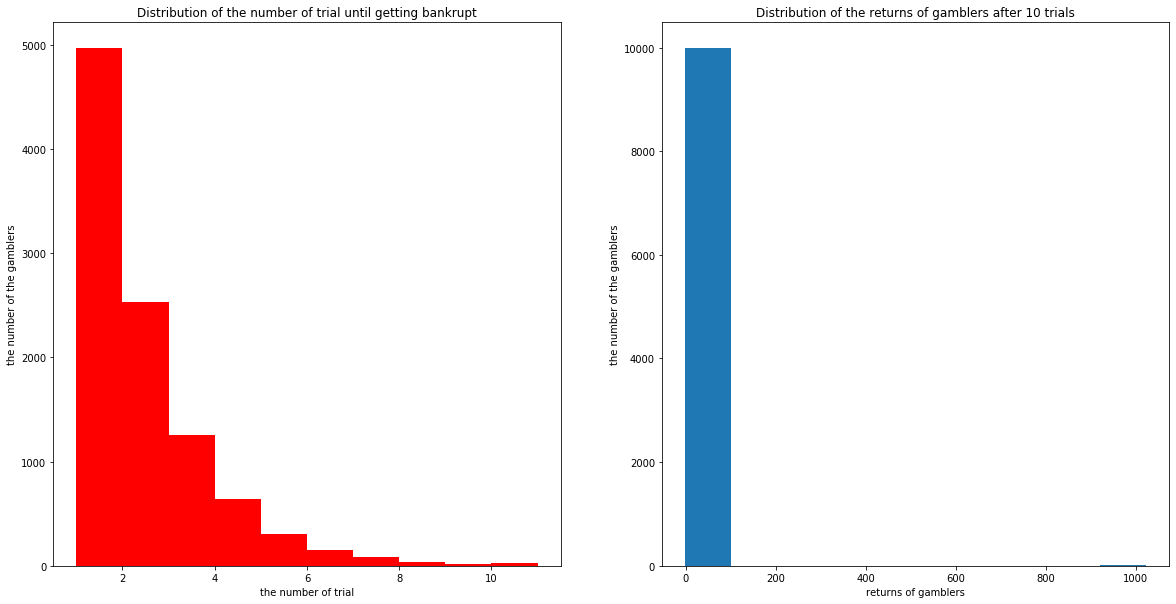

bankrupt_counter:Counter({1: 4966, 2: 2534, 3: 1250, 4: 636, 5: 303, 6: 147, 7: 83, 8: 39, 9: 19, 10: 12, 11: 11})
return_counter:Counter({-1.0: 9989, 1023.0: 11})


In [4]:
num_sim = 10000
max_trials = 10
prob_head = 0.5
bankroll = 100
bankrupt_line = 1 # If their bankroll is less than $1, they are considered bankrupt.
odds = 1
fraction = 1

simulations = [coin_simulation(max_trials, prob_head, bankroll, bankrupt_line, odds, fraction) for i in range(num_sim)]
return_sim = [ round(history[-1],2) for history, survival in simulations]
sur_sim = [ survival for history, survival in simulations]

bankrupt_counter = Counter(sur_sim)
ret_counter = Counter(return_sim)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(sur_sim, color='r',bins=range(1, max_trials+2))
ax[0].set_title("Distribution of the number of trial until getting bankrupt")
ax[0].set_xlabel("the number of trial")
ax[0].set_ylabel("the number of the gamblers")

ax[1].hist(return_sim)
ax[1].set_title(f"Distribution of the returns of gamblers after {max_trials} trials")
ax[1].set_xlabel("returns of gamblers")
ax[1].set_ylabel("the number of the gamblers")

plt.show()

print(f"bankrupt_counter:{bankrupt_counter}")
print(f"return_counter:{ret_counter}")

As you can see, most of the people go bankrupt after ten bets. Intuitively, you can see that it is foolish to bet all your bankroll on a single bet.

However, What is the expected return of a single bet in this game? It's $0.5. it is reasonable to bet $0.5 based on the expectation. But, you know it is not. This is the reason why we should cosider the growth rate rather than absolute return because we don't have infinite amount of money in the real world.

$$ E[r] = \frac{1}{2}*2-\frac{1}{2}*1=0.5$$

What happens if you bet on a portion of your fortune instead of all in? Let's check when people wager 20% or 80% of their fortune on each bet.

bankrupt_counter(fraction:0.2):Counter({11: 10000})
return_counter(fraction:0.2):Counter({-0.18: 2471, 0.22: 2088, -0.46: 2018, 0.83: 1168, -0.64: 1148, 1.75: 475, -0.76: 426, 3.13: 103, -0.84: 77, -0.89: 15, 5.19: 11})

bankrupt_counter(fraction:0.8):Counter({11: 3427, 7: 1503, 6: 1357, 3: 1255, 5: 968, 10: 811, 9: 679})
return_counter(fraction:0.8):Counter({-1.0: 6573, -0.95: 1679, -0.51: 1202, 3.41: 438, 38.67: 103, 356.05: 5})



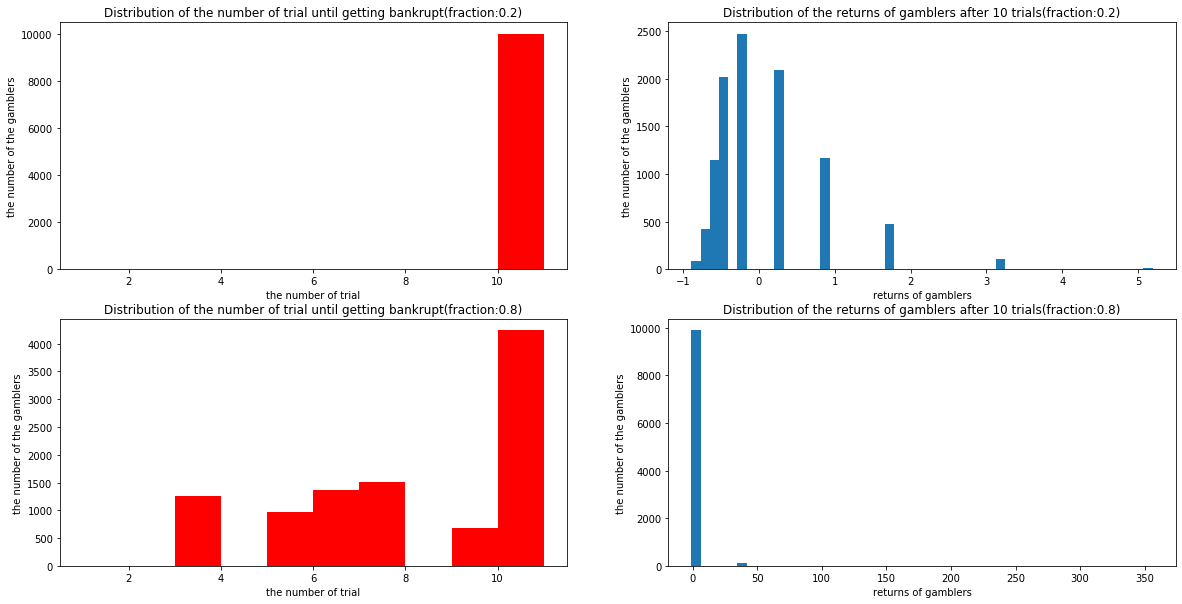

In [5]:
num_sim = 10000
max_trials = 10
prob_head = 0.5
bankroll = 100
bankrupt_line = 1 # If their bankroll is less than $1, they are considered bankrupt.
odds = 1
fraction = [0.2, 0.8]

figs, axes = plt.subplots(len(fraction), 2, figsize=(20, 10))

for option, ax in enumerate(axes):
    
    # Simulation
    simulations = [coin_simulation(max_trials, prob_head, bankroll, bankrupt_line, odds, fraction[option]) for i in range(num_sim)]
    return_sim = [ round(history[-1],2) for history, survival in simulations]
    sur_sim = [ survival for history, survival in simulations]

    bankrupt_counter = Counter(sur_sim)
    ret_counter = Counter(return_sim)

    
    # Plot
    ax[0].hist(sur_sim, color='r',bins=range(1,max_trials+2))
    ax[0].set_title(f"Distribution of the number of trial until getting bankrupt(fraction:{fraction[option]})")
    ax[0].set_xlabel("the number of trial")
    ax[0].set_ylabel("the number of the gamblers")
    
    ax[1].hist(return_sim, bins=50)
    ax[1].set_title(f"Distribution of the returns of gamblers after {max_trials} trials(fraction:{fraction[option]})")
    ax[1].set_xlabel("returns of gamblers")
    ax[1].set_ylabel("the number of the gamblers")
    
    print(f"bankrupt_counter(fraction:{fraction[option]}):{bankrupt_counter}")
    print(f"return_counter(fraction:{fraction[option]}):{ret_counter}")
    print()
plt.show()

Increasing betting size increases the probability of bankruptcy while lowering the betting size makes the final return smaller. We need to find the optimal betting size to maximize returns while reducing the probability of bankruptcy in multiple gambling games. Here comes the **Kelly Criterion**.

## What is Kelly Criterion?

The Kelly Criterion was first introduced the paper by the John Larry Kelly(1923~1965)[1] who was a research scientist at Bell Labs. It basically answers the question, "How much of my fortune should I bet on in this bet to maximize long-term grow rate of my wealth?".

## Kelly criterion

$$ X_{n} = X_{0}(1+bf)^{w}(1-af)^{l} $$


\begin{cases}
  X_{n} : \text{capital after n bets} \\
  X_{0} : \text{initial capital} \\
  f     : \text{fraction of the bankroll to be wagered on each bet} \\
  w     : \text{the number of win} \\
  l     : \text{the number of lose} \\
  b     : \text{profit per unit bet} \\
  a     : \text{loss per unit bet} \\
\end{cases}

For example, there is a coin tossing gamble. The coin is fair. If the head comes out, you can get three times as much money as you bet. But, if the tail comes out, you lose all your bet. Your initial capital is $100 and you won 7 times in 10 trials. 

\begin{cases}
  X_{n} : \text{capital after n bets} \\
  X_{0} : \text{\$100} \\
  w     : 7 \\
  l     : 3 \\
  b     : 2 \\
  a     : 1 \\
\end{cases}

what the Kelly criterion target is that maximizing the expected value of the (exponential) growth rate. $f$ is the fraction of the capital to be bet.

\begin{equation}
\begin{split}
    g(f) &= E[log(\frac{X_{n}}{X_{0}})] \\
         &= plog(1+bf)+qlog(1-af) \\
\end{split}
\end{equation}

\begin{cases}
  p     : \text{probability of win} \\
  q     : \text{probability of lose} \\
\end{cases}

The Kelly criterion says optimal fraction,

$$f^{*} = \frac{bp-aq}{ab}= \frac{p}{a}-\frac{q}{b}$$

## kelly betting

In [6]:
from mlfinlab.bet_sizing import kelly_betting

In the above example, the optimal fraction is below.

$$  f^{*} = \frac{0.5}{1}-\frac{0.5}{2} = 0.25  $$

In [7]:
optimal_fraction, expected_grow_rate = kelly_betting(win_probability=0.5, profit_unit=2, loss_unit=1)
print(f"optimal fraction : {optimal_fraction}")
print(f"expected_growth_rate: {expected_grow_rate:.3f}")

optimal fraction : 0.25
expected_growth_rate: 0.059


There is another game. It is a dice gamble. The dice is fair and there are numbers from one to six on each side. If you throw the dice and the number six comes out, this game will return nine times the money you bet. But other numbers come out, you lose all you bet. Between the coin game described above and the dice game, which game is advantageous, and how much money should you bet on each game?

First, check the expectation of return. Based on the expected return, the dice gamble looks good. ($ 0.666... > 0.5 $)

$$ E[r_{coin}] = \frac{1}{2}*2-\frac{1}{2}*1=0.5$$
$$ $$
$$ E[r_{dice}] = \frac{1}{6}*9-\frac{5}{6}*1=0.66666...$$

### Dice gamble

In [8]:
optimal_fraction, expected_grow_rate = kelly_betting(win_probability=1/6, profit_unit=8, loss_unit=1)
print(f"optimal fraction : {optimal_fraction}")
print(f"expected_growth_rate: {expected_grow_rate:.3f}")

optimal fraction : 0.062499999999999986
expected_growth_rate: 0.014


From the Kelly criterion, It's better to play coin gamble because we can expect higher growth rates in the long run. That's because it also takes into account the probability of losing all the money.

What if we don't follow the kelly betting?

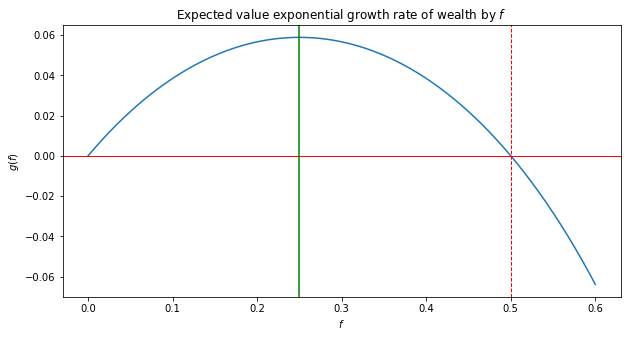

In [9]:
def grow_rate(odds, win_prob, fraction):
    p = win_prob
    q = 1-p
    return p*np.log(1+fraction*odds) + q*np.log(1-fraction)

x = np.linspace(0, 0.6, 1000)
y = [ grow_rate(2, 0.5, f) for f in x]
plt.figure(figsize=(10,5))
plt.plot(x, y)

plt.title(f"Expected value exponential growth rate of wealth by $f$")
plt.xlabel("$f$")
plt.ylabel("$g(f)$")

plt.axhline(y=0, color='r', linewidth=1)
plt.axvline(x=0.25, color='g', linewidth=1.5)
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=1)
plt.show()

If you make a bet larger than Kelly bet size, the expected growth rate will start to shrink and at some point the growth rate will be negative.

In the real world, we usually don't know the true probability of a win. So, we always estimate the probability. As a result, it is likely that we bet bigger than the actual kelly bet size. Sometimes, it leads to a negative expected growth rate.

For example, in the above example of a coin game, if you guessed the probability of a coin coming out front was $2/3$, the expected growth rate will be zero.

In [10]:
true_probability = 0.5
estimated_probability = 2/3

optimal_fraction, _ = kelly_betting(win_probability=estimated_probability, profit_unit=2, loss_unit=1)
print(f"optimal fraction : {optimal_fraction}")
print(f"expected_growth_rate: {grow_rate(2, true_probability, optimal_fraction):.3f}")

optimal fraction : 0.49999999999999994
expected_growth_rate: 0.000


Therefore, when using the kelly criterion, you should always keep in mind that you may do over betting.

## Kelly Investing

In [11]:
from mlfinlab.bet_sizing import kelly_investing

We can also appy the Kelly criterion to the stock market, but it is different from betting enviorment. Since it is not a binary event and there are infinte number of outcomes of investing, we have to use continuous probability distribution not a discrete one.

If we assume our return of equity is follow $N(\mu, \sigma^{2})$, then optimal leverage $f^{*}$ will generate the highest compounded growth rate of equity [2].($r$ is risk free)

$$ f^{*} = \frac{\mu-r}{\sigma^{2}} $$

The long-term growth rate $g(f^{*})$ is below by [1].

$$ g(f^{*}) = \frac{(m-r)^{2}}{2s^2} + r $$ 

When you apply Kelly Criterion in the real world,  you should keep in mind that the Kelly Criterion requires a continuous rebalancing of capital [2][3]. But, as you know, it's impossible to do it in the real world. At least, you should at least try to keep up with it such as rebalancing your portfolio once a day.

For example, You have $100 at first. The optimal leverage from the Kelly Criterion is 2 and the daily return is 10%.

In [12]:
def kelly_trader(portfolio_value, account_value, target_leverage, daily_return):
    
    profit = portfolio_value*daily_return
    #print(f"trade profit: ${profit:.3f}")
    
    new_account_value = account_value + profit
    #print(f"account value after trade: ${new_account_value:.3f}")
    
    new_target_portfolio_value = target_leverage * new_account_value
    #print(f"new target portfolio value: ${new_target_portfolio_value:.3f}")
    
    gap = new_target_portfolio_value - portfolio_value
    #print(f"gap: ${gap:.3f}")
    
    return new_account_value, new_target_portfolio_value, gap
    

In [13]:
account_value = 100
kelly_leverage = 2
portfolio_value = 2*account_value # You borrowed $100.
daily_return = 0.1

new_account, new_portfolio_value, additional_trade = kelly_trader(portfolio_value, account_value, kelly_leverage, daily_return)

print(f"Now, Your account value is ${new_account}")
print(f"You have to buy ${additional_trade} to keep the leverage({kelly_leverage}) ratio.")
print(f"Your portfolio value at the end of the day should be ${new_portfolio_value}")

Now, Your account value is $120.0
You have to buy $40.0 to keep the leverage(2) ratio.
Your portfolio value at the end of the day should be $240.0


Let's use synthetic data and find out what happen if we apply the Kelly criterion to investing. we assume there are 252 trading days in a year and risk free rate is zero.

In [14]:
# mean of annual return
mu=0.05
# std of annual return
sigma=0.216

def sample_daily_returns(mu, sigma, year, seed):
    np.random.seed(seed)
    return np.random.normal(mu/252, sigma/np.sqrt(252), 252*year)

# 10 years of returns
return_samples = sample_daily_returns(mu, sigma, seed=9999, year=10)

In [15]:
return_history = return_samples

# Calculating leverage and expected growth rate
kelly_leverage, growth_rate = kelly_investing(return_history, 0, 252)
print(f"kelly leverage: {kelly_leverage}")
print(f"growth rate: {growth_rate}")

initial_capital = 100.
account_value = initial_capital
portfolio_value = kelly_leverage*account_value

account_value_history = [initial_capital,]
profit_history = [0,]
portfolio_value_history = [portfolio_value,]

# Simulates trade
for r in return_history:
    account_value, portfolio_value, gap = kelly_trader(portfolio_value, account_value, kelly_leverage, r)
    
    account_value_history.append(account_value)
    profit_history.append(profit_history)
    portfolio_value_history.append(portfolio_value)

kelly leverage: 2.245683322279959
growth rate: 0.12156375478151284


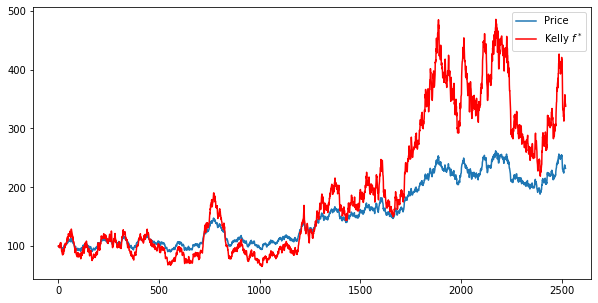

In [16]:
plt.figure(figsize=(10,5))
stock_price = 100*np.cumprod(1+return_history)
plt.plot(stock_price, label="Price")
plt.plot(account_value_history, color='r', label="Kelly $f^*$")
plt.legend()
plt.show()

In [17]:
account_value_history[-1], stock_price[-1]

(337.77595158074087, 232.0401734666087)

The Kelly results look great, but the strategy following the Kelly Criterion has much bigger volatility than the other. You should be aware that we assume that the distribution of return follows gaussian and there is no constraint like training costs.

### Fraction kelly

What happen if we do not follow the exact Kelly Criterion? For instance, If you bet more than twice of the Kelly leverage, the result will not be good because it makes your expected growth rate zero to use about twice the Kelly leverage,  $2f^*$ [1]. 

In [18]:
fractions = [0.5, 1.0, 1.5, 2.0]

In [19]:
return_history = return_samples
fraction_kelly_histories = []

for c in fractions:
    # Calculating leverage and expected growth rate
    kelly_leverage, growth_rate = kelly_investing(return_history, 0, 252)
    
    # Fraction kelly
    kelly_leverage = c*kelly_leverage
    print(f"{c} * kelly leverage: {kelly_leverage}")
    print(f"growth rate: {growth_rate}\n")
    
    initial_capital = 100.
    account_value = initial_capital
    portfolio_value = kelly_leverage*account_value

    account_value_history = [initial_capital,]
    profit_history = [0,]
    portfolio_value_history = [portfolio_value,]
    
    # Simulates trade
    for r in return_history:
        account_value, portfolio_value, gap = kelly_trader(portfolio_value, account_value, kelly_leverage, r)

        account_value_history.append(account_value)
        profit_history.append(profit_history)
        portfolio_value_history.append(portfolio_value)
    
    fraction_kelly_histories.append(account_value_history)

0.5 * kelly leverage: 1.1228416611399794
growth rate: 0.12156375478151284

1.0 * kelly leverage: 2.245683322279959
growth rate: 0.12156375478151284

1.5 * kelly leverage: 3.3685249834199382
growth rate: 0.12156375478151284

2.0 * kelly leverage: 4.491366644559918
growth rate: 0.12156375478151284



In [20]:
# change type to pandas data frame type
fraction_kelly_histories = np.array(fraction_kelly_histories).T
fraction_kelly_hist_df = pd.DataFrame(fraction_kelly_histories)
fraction_kelly_hist_df.columns = [ f"{c:.1f}$f^*$"for c in fractions]

# add stock price (It is just buy and hold)
stock_price = pd.Series(100*np.cumprod(1+return_history))
fraction_kelly_hist_df['price'] = stock_price
fraction_kelly_hist_df['price'] = fraction_kelly_hist_df['price'].shift(1)
fraction_kelly_hist_df['price'][0] = 100.

In [21]:
fraction_kelly_hist_df.head()

,0.5$f^*$,1.0$f^*$,1.5$f^*$,2.0$f^*$,price
0,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.235391,98.470783,97.706174,96.941566,99.319042
2,100.154897,100.295623,100.422181,100.534569,100.138641
3,100.250465,100.487029,100.709651,100.918291,100.223740
4,99.524736,99.032146,98.522493,97.996038,99.577580


The kelly leverage outcome is the best. but, it has high volatility. You can see the worst result when we do bet more than twice of the Kelly leverage.

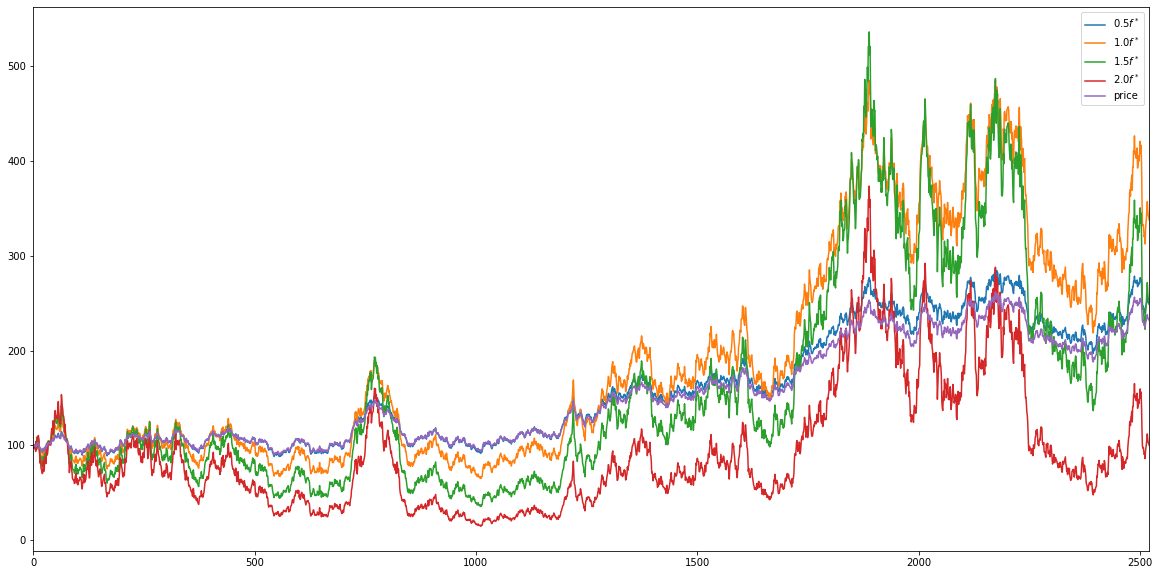

In [22]:
fraction_kelly_hist_df.plot(figsize=(20,10))

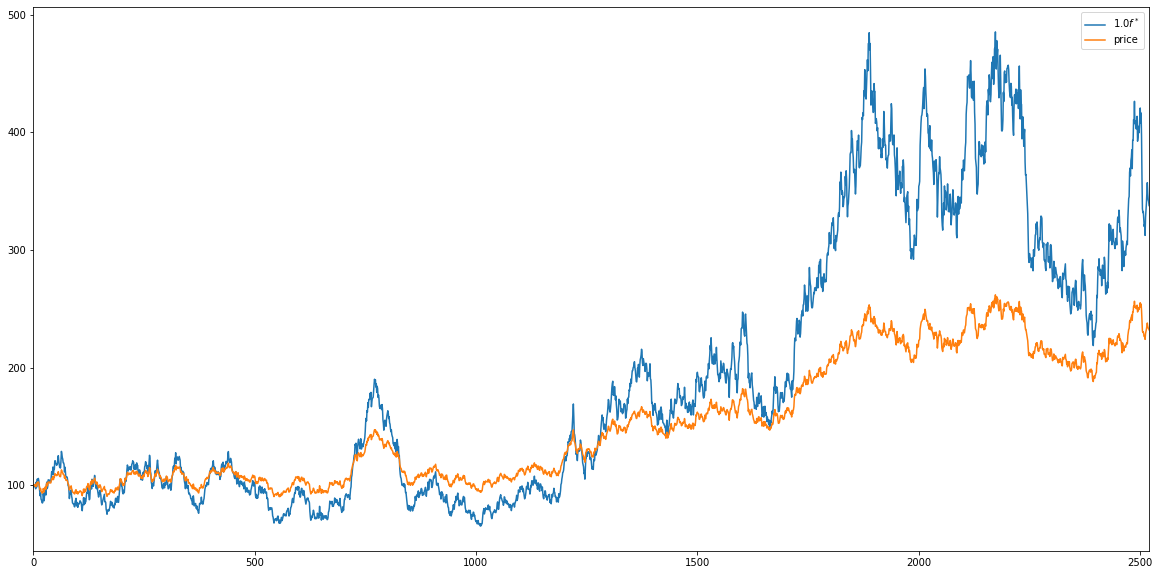

In [23]:
# Compare between Kelly leverage and 'buying and holding'
fraction_kelly_hist_df.iloc[:, [1, -1]].plot(figsize=(20,10))

In addition, as seen in the above example of coin gambling, we are always exposed to the possibility of over betting which might lead to the negative growth rate of the wealth. Therefore, it is reasonable not to use the exact Kelly leverage. Many practitioners suggest using half of the Kelly leverage. We can view Kelly's optimal leverage as the upper bound of the leverage [2].

## kelly allocation

In [24]:
from mlfinlab.bet_sizing import kelly_allocation

we can use the Kelly criterion not only to the single asset or strategy but also to the multiple assets or strategies. In this case, we should consider correlation between them. 

Based on the paper by Thorp [1], the optimal allocation and the expected growth return are below.

$$ F^{*} = C^{-1}[M-R] $$


$$ g(F^{*}) = r + \frac{(F^{*})^{T}CF^{*}}{2} $$

$$ M: (m_{1}, m_{2}, ..., m_{n})^{T}, m_{i}  \text{is the drift rate of the } ith \text{ security} $$

$$ C: \text{covariance matrix}, C_{ij} \text{is the covariance of the } ith \text{ and } jth \text{ securities} $$

$$ F^{T}: (f_{1}, f_{2}, ...,f_{n}) $$

$$ R: (f_{1}, f_{2}, ...,f_{n})^{T} $$

$$ f_{0} : \text{riskless security with portfolio fractions} $$

$$ f_{1}, ..., f_{n} : \text{n securities with portfolio fractions}$$ 

Let's check this with real data.($\text{risk free rate}$ is 0.02)

In [25]:
stock_prices = pd.read_csv("mlfinlab/tests/test_data/stock_prices.csv", index_col=0)
assets_df = stock_prices[["SPY", "EEM", "TLT"]]
assets_return_df = (assets_df/assets_df.shift(1)-1).dropna()

In [26]:
kelly_allocations, growth_rate = kelly_allocation(assets_return_df, risk_free_rate=0.02, annualize_factor=252)

for ticker, kelly in zip(["SPY", "EEM", "TLT"], kelly_allocations):
    print(f"{ticker}: {kelly:.2f}")

print(f"Total leverage: {np.sum(abs(kelly_allocations)):.2f}")    
print(f"\n Annualized compounded growth rate: {growth_rate:.2f}")

SPY: 5.64
EEM: -2.68
TLT: 2.81
Total leverage: 11.12

 Annualized compounded growth rate: 0.21


## Conclusion

Here, we explore the applications of Kelly criterion which asymptotically maximizes the expected compound growth rate of the wealth [1]. It can be a great framework of money management that seeks to find a sweet spot between absolute return and risk in the long-term. But in the real world, we are more likely to make a bet bigger than the Kelly Criterion and experience high volatility. Therefore, it is encouraged to use less wisely than to follow the Kelly Criterion correctly.

## Reference
- [1] A New Inerpretation of Information Rate(1956) By John Larry Kelly.
- [2] Algorithmic Trading : Winning Strategies and Their Rationale By Ernest P. Chan, John Wiley & Sons, 2013.
- [3] Successful Algorithmic Trading: Applying the scientific method for profitable trading results By Michael L. Halls-Moore.